前面的学习，我们已经知道如何用神经网络解决分类问题和回归问题，而且也看到了机器学习的核心难题：**过拟合**。

本章会将你对这些问题的直觉固化为解决深度学习问题的可靠的概念框架。我们将把所有这些概念——
**模型评估、数据预处理、特征工程、解决过拟合**——整合为详细的七步工作流程，用来解决任何机器学习任务。

# 1 机器学习的四个分支

* **监督学习**：是当前深度学习的主要形式，行业应用非常广泛。
    * 分类
    * 回归
    * **序列生成（sequence generation）**。给定一张图像，预测描述图像的文字。序列生成有时可以被重新表示为一系列分类问题，比如反复预测序列中的单词或标记。
    * **语法树预测（syntax tree prediction）**。给定一个句子，预测其分解生成的语法树。
    * **目标检测（object detection）**。给定一张图像，在图中特定目标的周围画一个边界框。这个问题也可以表示为分类问题（给定多个候选边界框，对每个框内的目标进行分类）或分类与回归联合问题（用向量回归来预测边界框的坐标）。
    * **图像分割（image segmentation）**。给定一张图像，在特定物体上画一个像素级的掩模（mask）。
    
* **无监督学习**
    * 降维（dimensionality reduction）
    * 聚类（clustering）
    
* **自监督学习**：自监督学习是监督学习的一个特例，它与众不同，值得单独归为一类。自监督学习是没有人工标注的标签的监督学习，你可以将它看作没有人类参与的监督学习。标签仍然存在（因为总要有什么东西来监督学习过程），但它们是从输入数据中生成的，通常是使用启发式算法生成的。
    * **自编码器（autoencoder）是有名的自监督学习的例子，其生成的目标就是未经修改的输入**。同样，给定视频中过去的帧来预测下一帧，或者给定文本中前面的词来预测下一个词，都是自监督学习的例子［这两个例子也属于**时序监督学习（temporally supervised learning）， 即用未来的输入数据作为监督］**。注意，**监督学习、自监督学习和无监督学习**之间的区别有时很模糊，这三个类别更像是没有明确界限的连续体。**自监督学习可以被重新解释为监督学习或无监督学习，这取决于你关注的是学习机制还是应用场景**。
    
* **强化学习**：智能体（agent）接收有关其环境的信息，并学会选择使某种奖励最大化的行动。强化学习主要集中在研究领域，除游戏外还没有取得实践上的重大成功。但是，我们期待强化学习未来能够实现越来越多的实际应用：自动驾驶汽车、机器人、资源管理、教育等。强化学习的时代已经到来，或即将到来。

![image.png](../img/04/术语.png)

# 2 评估机器学习模型

我们将数据划分为**训练集、验证集和测试集**。我们没有在训练模型的相同数据上对模型进行评估，其原因很快显而易见：仅仅几轮过后，三个模型都开始过拟合。也就是说，随着训练的进行，模型在训练数据上的性能始终在提高，但在前所未见的数据上的性能则不再变化或者开始下降。

机器学习的目的是得到可以泛化（generalize）的模型，即在前所未见的数据上表现很好的模型，而过拟合则是核心难点。你只能控制可以观察的事情，所以能够可靠地衡量模型的泛化能力非常重要。后面几节将介绍降低过拟合以及将泛化能力最大化的方法。

本节重点介绍**如何衡量泛化能力，即如何评估机器学习模型**。

## 2.1 训练集、验证集和测试集

* 评估模型的重点是将数据划分为三个集合：训练集、验证集和测试集。**在训练数据上训练模型，在验证数据上评估模型。一旦找到了最佳参数，就在测试数据上最后测试一次**。

* 你可能会问，**为什么不是两个集合**：**一个训练集和一个测试集？在训练集上训练模型，然后在测试集上评估模型。这样简单得多！**

* 原因在于**开发模型时总是需要调节模型配置**，比如**选择层数或每层大小［这叫作模型的超参数（hyperparameter），以便与模型参数（即权重）区分开］**。这个调节过程**需要使用模型在验证数据上的性能作为反馈信号**。这个调节过程本质上就是一种学习：**在某个参数空间中寻找良好的模型配置**。因此，**如果基于模型在验证集上的性能来调节模型配置，会很快导致模型在验证集上过拟合，即使你并没有在验证集上直接训练模型也会如此**。

* 造成这一现象的关键在于**信息泄露（information leak）**。**每次基于模型在验证集上的性能来调节模型超参数，都会有一些关于验证数据的信息泄露到模型中**。**如果对每个参数只调节一次，那么泄露的信息很少，验证集仍然可以可靠地评估模型。但如果你多次重复这一过程（运行一次实验，在验证集上评估，然后据此修改模型），那么将会有越来越多的关于验证集的信息泄露到模型中。**

* 最后，你得到的模型在验证集上的性能非常好（人为造成的），因为这正是你优化的目的。你关心的是模型在全新数据上的性能，而不是在验证数据上的性能，因此你需要使用一个完全不同的、前所未见的数据集来评估模型，它就是测试集。**你的模型一定不能读取与测试集有关的任何信息，既使间接读取也不行**。**如果基于测试集性能来调节模型，那么对泛化能力的衡量是不准确的**。**将数据划分为训练集、验证集和测试集可能看起来很简单，但如果可用数据很少，还有几种高级方法可以派上用场**。我们先来介绍三种经典的评估方法：**简单的留出验证**、 **K 折验证**，以及**带有打乱数据的重复 K 折验证**。

**1. 简单的留出验证**

留出一定比例的数据作为测试集。在剩余的数据上训练模型，然后在测试集上评估模型。如前所述，为了防止信息泄露，你不能基于测试集来调节模型，所以还应该保留一个验证集。留出验证（hold-out validation）的示意图见图

![image.png](../img/04/留出验证.png)

```python
num_validation_samples = 10000

# 通常需要打乱数据
np.random.shuffle(data) 

# 定义验证集
validation_data = data[:num_validation_samples]
data = data[num_validation_samples:]

# 定义训练集
training_data = data[:]

# 在训练数据上训练模型，并在验证数据上评估模型
model = get_model()
model.train(training_data)
validation_score = model.evaluate(validation_data)

# 现在你可以调节模型、重新训练、评估，然后再次调节……
# 一旦调节好超参数，通常就在所有非测试数据上从头开始训练最终模型
model = get_model()
model.train(np.concatenate([training_data,validation_data]))
test_score = model.evaluate(test_data)
```

> 有一个缺点：如果可用的数据很少，那么可能验证集和测试集包含的样本就太少，从而无法在统计学上代表数据。这个问题很
容易发现：如果在划分数据前进行不同的随机打乱，最终得到的模型性能差别很大，那么就存在这个问题。

**2. K 折验证**

K 折验证（K-fold validation）将数据划分为大小相同的 K 个分区。 对于每个分区 i，在剩余的 K-1 个分区上训练模型，然后在分区 i 上评估模型。最终分数等于 K 个分数的平均值。对于不同的训练集 - 测试集划分，如果模型性能的变化很大，那么这种方法很有用。与留出验证一样，这种方法也需要独立的验证集进行模型校正。K 折交叉验证的示意图见图

![image.png](../img/04/三折验证.png)

```python
k = 4
num_validation_samples = len(data) // k

np.random.shuffle(data)

validation_scores = []
for fold in range(k):
    # 选择验证数据分区
    validation_data = data[num_validation_samples * fold:num_validation_samples * (fold + 1)]
    # 使用剩余数据作为训练数据。注意，+ 运算符是列表合并，不是求和
    training_data = data[:num_validation_samples * fold] + data[num_validation_samples * (fold + 1):]
    
    # 创建一个全新的模型实例（未训练）
    model = get_model()
    model.train(training_data)
    validation_score = model.evaluate(validation_data)
    validation_scores.append(validation_score)

# 最终验证分数： K 折验证分数的平均值
validation_score = np.average(validation_scores)

# 在所有非测试数据上训练最终模型
model = get_model()
model.train(data)
test_score = model.evaluate(test_data)
```

**3. 带有打乱数据的重复 K 折验证**

**如果可用的数据相对较少，而你又需要尽可能精确地评估模型，那么可以选择带有打乱数据的重复 K 折验证（iterated K-fold validation with shuffling）**。我发现这种方法在 Kaggle 竞赛中特别有用。具体做法是**多次使用 K 折验证，在每次将数据划分为 K 个分区之前都先将数据打乱。最终分数是每次 K 折验证分数的平均值**。注意，这种方法**一共要训练和评估 P×K 个模型（P是重复次数），计算代价很大**。

## 2.2 评估模型的注意事项

选择模型评估方法时，需要注意以下几点。

* **数据代表性（data representativeness）**。你希望训练集和测试集都能够代表当前数据。例如，你想要对数字图像进行分类，而图像样本是按类别排序的，如果你将前 80% 作为训练集，剩余 20% 作为测试集，那么会导致训练集中只包含类别 0~7，而测试集中只包含类别 8~9。这个错误看起来很可笑，却很常见。因此，**在将数据划分为训练集和测试集之前，通常应该随机打乱数据**。

* **时间箭头（the arrow of time）**。如果想要根据过去预测未来（比如明天的天气、股票走势等），那么在**划分数据前你不应该随机打乱数据，因为这么做会造成时间泄露（temporalleak）**：你的模型将**在未来数据上得到有效训练**。在这种情况下，你**应该始终确保测试集中所有数据的时间都晚于训练集数据**。

* **数据冗余（redundancy in your data）**。如果**数据中的某些数据点出现了两次**（这在现实中的数据里十分常见），那么**打乱数据并划分成训练集和验证集会导致训练集和验证集之间的数据冗余**。从效果上来看，你是**在部分训练数据上评估模型，这是极其糟糕的！一定要确保训练集和验证集之间没有交集**。

# 3 数据预处理、特征工程和特征学习

除模型评估之外，在深入研究模型开发之前，我们还必须解决另一个重要问题：将数据输入神经网络之前，如何准备输入数据和目标？许多数据预处理方法和特征工程技术都是和特定领域相关的（比如只和文本数据或图像数据相关）

## 3.1 神经网络的数据预处理

数据预处理的目的是使原始数据更适于用神经网络处理，包括向量化、标准化、处理缺失值和特征提取。

**1. 向量化**

神经网络的所有输入和目标都必须是浮点数张量（在特定情况下可以是整数张量）。无论处理什么数据（声音、图像还是文本），都必须首先将其转换为张量，这一步叫作数据向量化（data vectorization）。例如，在前面两个文本分类的例子中，开始时文本都表示为整数列表（代表单词序列），然后我们用 one-hot 编码将其转换为 float32 格式的张量。在手写数字分类和预测房价的例子中，数据已经是向量形式，所以可以跳过这一步。

**2. 值标准化**

在手写数字分类的例子中，开始时图像数据被编码为 0~255 范围内的整数，表示灰度值。将这一数据输入网络之前，你需要将其转换为 float32 格式并除以 255，这样就得到 0~1 范围内的浮点数。同样，预测房价时，开始时特征有各种不同的取值范围，有些特征是较小的浮点数，

有些特征是相对较大的整数。将这一数据输入网络之前，你需要对每个特征分别做标准化，使
其均值为 0、标准差为 1。

一般来说，将取值相对较大的数据（比如多位整数，比网络权重的初始值大很多）或异质数据（heterogeneous data，比如数据的一个特征在 0~1 范围内，另一个特征在 100~200 范围内）输入到神经网络中是不安全的。这么做可能导致较大的梯度更新，进而导致网络无法收敛。为了让网络的学习变得更容易，输入数据应该具有以下特征。

    * 取值较小：大部分值都应该在 0~1 范围内。
    * 同质性（homogenous）：所有特征的取值都应该在大致相同的范围内。

此外，下面这种更严格的标准化方法也很常见，而且很有用，虽然不一定总是必需的（例如，对于数字分类问题就不需要这么做）。

    * 将每个特征分别标准化，使其平均值为 0。
    * 将每个特征分别标准化，使其标准差为 1。
    
这对于 Numpy 数组很容易实现。

```python
# 假设 x 是一个形状为 (samples,features) 的二维矩阵
x -= x.mean(axis=0)
x /= x.std(axis=0)
```

**3. 处理缺失值**

你的数据中有时可能会有缺失值。例如在房价的例子中，第一个特征（数据中索引编号为0 的列）是人均犯罪率。如果不是所有样本都具有这个特征的话，怎么办？那样你的训练数据或测试数据将会有缺失值。

一般来说，对于神经网络，将缺失值设置为 0 是安全的，只要 0 不是一个有意义的值。网络能够从数据中学到 0 意味着缺失数据，并且会忽略这个值。

注意，如果测试数据中可能有缺失值，而网络是在没有缺失值的数据上训练的，那么网络不可能学会忽略缺失值。在这种情况下，你应该人为生成一些有缺失项的训练样本：多次复制一些训练样本，然后删除测试数据中可能缺失的某些特征。


## 3.2 特征工程


# 4 过拟合与欠拟合


## 4.1 减小网络大小


## 4.2 添加权重正则化


## 4.3 添加 dropout 正则化


# 5 机器学习的通用工作流程

介绍一种可用于解决任何机器学习问题的通用模板：

* （1）定义问题，收集数据集
非平稳问题（nonstationary problem）

* （2）选择衡量成功的指标
    * 对于平衡分类问题（每个类别的可能性相同），精度和接收者操作特征曲线下面积（area under the receiver operating characteristic curve， ROC AUC）是常用的指标。
    * 对于类别不平衡的问题，你可以使用准确率和召回率。
    * 对于排序问题或多标签分类，你可以使用平均准确率均值（mean average precision）。

* （3）确定评估方法

一旦明确了目标，你必须确定如何衡量当前的进展。前面介绍了三种常见的评估方法。
    * **留出验证集**。数据量很大时可以采用这种方法。
    * **K 折交叉验证**。如果留出验证的样本量太少，无法保证可靠性，那么应该选择这种方法。
    * **重复的 K 折验证**。如果可用的数据很少，同时模型评估又需要非常准确，那么应该使用这种方法。
只需选择三者之一。大多数情况下，第一种方法足以满足要求。

* （4）准备数据

一旦知道了要训练什么、要优化什么以及评估方法，那么你就几乎已经准备好训练模型了。但首先你应该将数据格式化，使其可以输入到机器学习模型中（这里假设模型为深度神经网络）。
    * 如前所述，应该将数据格式化为张量。
    * 这些张量的取值通常应该缩放为较小的值，比如在 [-1, 1] 区间或 [0, 1] 区间。
    * 如果不同的特征具有不同的取值范围（异质数据），那么应该做数据标准化。
    * 你可能需要做特征工程，尤其是对于小数据问题。
准备好输入数据和目标数据的张量后，你就可以开始训练模型了。

* （5）开发比基准更好的模型

这一阶段的目标是获得统计功效（statistical power），即开发一个小型模型，它能够打败纯随机的基准（dumb baseline）。在 MNIST 数字分类的例子中，任何精度大于 0.1 的模型都可以说具有统计功效；在 IMDB 的例子中，任何精度大于 0.5 的模型都可以说具有统计功效。注意，不一定总是能获得统计功效。如果你尝试了多种合理架构之后仍然无法打败随机基准，那么原因可能是问题的答案并不在输入数据中。要记住你所做的两个假设。

    * 假设输出是可以根据输入进行预测的。
    * 假设可用的数据包含足够多的信息，足以学习输入和输出之间的关系。
    
这些假设很可能是错误的，这样的话你需要从头重新开始。

    * 最后一层的激活。它对网络输出进行有效的限制。例如， IMDB 分类的例子在最后一层使用了 sigmoid，回归的例子在最后一层没有使用激活，等等。
    * 损失函数。它应该匹配你要解决的问题的类型。例如， IMDB 的例子使用 binary_crossentropy、回归的例子使用 mse， 等等。
    * 优化配置。你要使用哪种优化器？学习率是多少？大多数情况下，使用 rmsprop 及其默认的学习率是稳妥的。

关于损失函数的选择，需要注意，直接优化衡量问题成功的指标不一定总是可行的。有时难以将指标转化为损失函数，要知道损失函数需要在只有小批量数据时即可计算（理想情况下，只有一个数据点时，损失函数应该也是可计算的），而且还必须是可微的（否则无法用反向传播来训练网络）。例如，广泛使用的分类指标 ROC AUC 就不能被直接优化。因此在分类任务中，常见的做法是优化 ROC AUC 的替代指标，比如交叉熵。一般来说， 你可以认为交叉熵越小，ROC AUC 越大。

![image.png](../img/04/最后一层激活和损失函数.png)

* （6）扩大模型规模：开发过拟合的模型

一旦得到了具有统计功效的模型，问题就变成了：模型是否足够强大？它是否具有足够多的层和参数来对问题进行建模？例如，只有单个隐藏层且只有两个单元的网络，在 MNIST 问题上具有统计功效，但并不足以很好地解决问题。请记住，机器学习中无处不在的对立是优化和泛化的对立，理想的模型是刚好在欠拟合和过拟合的界线上，在容量不足和容量过大的界线上。为了找到这条界线，你必须穿过它。要搞清楚你需要多大的模型，就必须开发一个过拟合的模型，这很简单。

    * (1) 添加更多的层。
    * (2) 让每一层变得更大。
    * (3) 训练更多的轮次。

要始终监控训练损失和验证损失，以及你所关心的指标的训练值和验证值。如果你发现模型在验证数据上的性能开始下降，那么就出现了过拟合。

下一阶段将开始正则化和调节模型，以便尽可能地接近理想模型，既不过拟合也不欠拟合。

* （7）模型正则化与调节超参数

这一步是最费时间的：你将不断地调节模型、训练、在验证数据上评估（这里不是测试数据）、再次调节模型，然后重复这一过程，直到模型达到最佳性能。你应该尝试以下几项。

    * 添加 dropout。
    * 尝试不同的架构：增加或减少层数。
    * 添加 L1 和 / 或 L2 正则化。
    * 尝试不同的超参数（比如每层的单元个数或优化器的学习率），以找到最佳配置。
    * （可选）反复做特征工程：添加新特征或删除没有信息量的特征。

请注意：每次使用验证过程的反馈来调节模型，都会将有关验证过程的信息泄露到模型中。如果只重复几次，那么无关紧要；但如果系统性地迭代许多次，最终会导致模型对验证过程过拟合（即使模型并没有直接在验证数据上训练）。这会降低验证过程的可靠性。

一旦开发出令人满意的模型配置，你就可以在所有可用数据（训练数据 + 验证数据）上训练最终的生产模型，然后在测试集上最后评估一次。如果测试集上的性能比验证集上差很多，那么这可能意味着你的验证流程不可靠，或者你在调节模型参数时在验证数据上出现了过拟合。在这种情况下，你可能需要换用更加可靠的评估方法，比如重复的 K 折验证。

# 减小网络大小

In [1]:
from keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

Using TensorFlow backend.


In [2]:
# 原始模型
from keras import models
from keras import layers

original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

In [3]:
# 容量更小的模型
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])

In [4]:
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512,
                                   validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 12s 499us/step - loss: 0.4440 - acc: 0.8251 - val_loss: 0.3286 - val_acc: 0.8835
Epoch 2/20
25000/25000 [==============================] - 8s 330us/step - loss: 0.2573 - acc: 0.9078 - val_loss: 0.2864 - val_acc: 0.8882
Epoch 3/20
25000/25000 [==============================] - 8s 306us/step - loss: 0.1991 - acc: 0.9292 - val_loss: 0.2821 - val_acc: 0.8891 3s - loss: 0.1937 - ETA: 2s - loss: 0.1975 - acc: - ETA: 1s - loss: 0.1
Epoch 4/20
25000/25000 [==============================] - 8s 313us/step - loss: 0.1666 - acc: 0.9412 - val_loss: 0.2939 - val_acc: 0.88441628 - a
Epoch 5/20
25000/25000 [==============================] - 8s 319us/step - loss: 0.1435 - acc: 0.9501 - val_loss: 0.3116 - val_acc: 0.8804
Epoch 6/20
25000/25000 [==============================] - 8s 315us/step - loss: 0.1257 - acc: 0.9558 - val_loss: 0.3483 - val_acc: 0.8721
Epoch 7/20
25000/25000 [=================

In [5]:
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512,
                                       validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 9s 342us/step - loss: 0.5804 - acc: 0.7027 - val_loss: 0.5309 - val_acc: 0.7558
Epoch 2/20
25000/25000 [==============================] - 8s 321us/step - loss: 0.4843 - acc: 0.8455 - val_loss: 0.4876 - val_acc: 0.8280
Epoch 3/20
25000/25000 [==============================] - 8s 307us/step - loss: 0.4389 - acc: 0.8920 - val_loss: 0.4663 - val_acc: 0.8497
Epoch 4/20
25000/25000 [==============================] - 8s 312us/step - loss: 0.4077 - acc: 0.9154 - val_loss: 0.4526 - val_acc: 0.8663
Epoch 5/20
25000/25000 [==============================] - 8s 316us/step - loss: 0.3832 - acc: 0.9306 - val_loss: 0.4513 - val_acc: 0.8620
Epoch 6/20
25000/25000 [==============================] - 8s 324us/step - loss: 0.3620 - acc: 0.9415 - val_loss: 0.4424 - val_acc: 0.8728oss: 0.3620 - acc: 0.9
Epoch 7/20
25000/25000 [==============================] - 8s 312us/step - loss: 0.3425 - acc: 0.9515

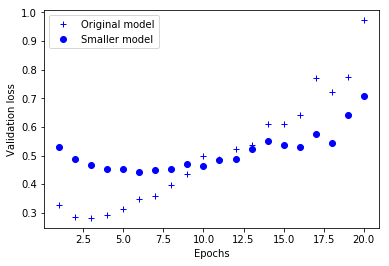

In [6]:
epochs = range(1, 21)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

%matplotlib inline
import matplotlib.pyplot as plt

# b+ is for "blue cross"
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
# "bo" is for "blue dot"
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

In [7]:
# 容量更大的模型
bigger_model = models.Sequential()
bigger_model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
bigger_model.add(layers.Dense(512, activation='relu'))
bigger_model.add(layers.Dense(1, activation='sigmoid'))

bigger_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['acc'])

In [8]:
bigger_model_hist = bigger_model.fit(x_train, y_train,
                                     epochs=20,
                                     batch_size=512,
                                     validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 11s 435us/step - loss: 0.4630 - acc: 0.7954 - val_loss: 0.2848 - val_acc: 0.8882
Epoch 2/20
25000/25000 [==============================] - 10s 407us/step - loss: 0.2237 - acc: 0.9120 - val_loss: 0.3084 - val_acc: 0.8730
Epoch 3/20
25000/25000 [==============================] - 10s 388us/step - loss: 0.1352 - acc: 0.9494 - val_loss: 0.3076 - val_acc: 0.8851
Epoch 4/20
25000/25000 [==============================] - 10s 390us/step - loss: 0.0763 - acc: 0.9792 - val_loss: 0.4175 - val_acc: 0.8808
Epoch 5/20
25000/25000 [==============================] - 10s 410us/step - loss: 0.0818 - acc: 0.9856 - val_loss: 0.4809 - val_acc: 0.8818
Epoch 6/20
25000/25000 [==============================] - 10s 387us/step - loss: 0.0728 - acc: 0.9882 - val_loss: 0.4978 - val_acc: 0.8729
Epoch 7/20
25000/25000 [==============================] - 10s 394us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.

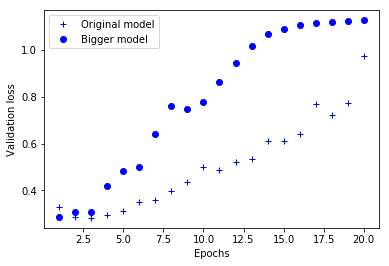

In [9]:
bigger_model_val_loss = bigger_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_val_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

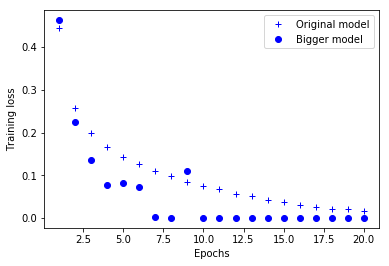

In [10]:
original_train_loss = original_hist.history['loss']
bigger_model_train_loss = bigger_model_hist.history['loss']

plt.plot(epochs, original_train_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_train_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()

plt.show()

# 添加权重正则化

奥卡姆剃刀（Occam’s razor）原理：如果一件事情有两种解释，那么最可能正确的解释就是最简单的那个，即假设更少的那个。这个原理也适用于神经网络学到的模型：给定一些训练数据和一种网络架构，很多组权重值（即很多模型）都可以解释这些数据。简单模型比复杂模型更不容易过拟合。

这里的简单模型（simple model）是指参数值分布的熵更小的模型（或参数更少的模型，比如上一节的例子）。因此，一种常见的降低过拟合的方法就是强制让模型权重只能取较小的值，从而限制模型的复杂度，这使得权重值的分布更加规（regular）。这种方法叫作权重正则化（weight regularization），其实现方法是向网络损失函数中添加与较大权重值相关的成（cost）。

这个成本有两种形式。

* L1 正则化（L1 regularization）：添加的成本与权重系数的绝对值［权重的 L1 范数（norm）］成正比。
* L2 正则化（L2 regularization）：添加的成本与权重系数的平方（权重的 L2 范数）成正比。神经网络的 L2 正则化也叫权重衰减（weight decay）。不要被不同的名称搞混，权重衰减与 L2 正则化在数学上是完全相同的。

在 Keras 中，添加权重正则化的方法是向层传递权重正则化项实例（weight regularizer instance）作为关键字参数。下列代码将向电影评论分类网络中添加 L2 权重正则化。

In [11]:
# 向模型添加 L2 权重正则化
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, 
                          kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', 
                          input_shape=(10000,)))
l2_model.add(layers.Dense(16, 
                          kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

In [12]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 9s 367us/step - loss: 0.4879 - acc: 0.8152 - val_loss: 0.3895 - val_acc: 0.8656
Epoch 2/20
25000/25000 [==============================] - 8s 316us/step - loss: 0.3100 - acc: 0.9061 - val_loss: 0.3306 - val_acc: 0.8891
Epoch 3/20
25000/25000 [==============================] - 8s 315us/step - loss: 0.2657 - acc: 0.9202 - val_loss: 0.3301 - val_acc: 0.8872: 3s - loss: 0.2621 - - ETA: 
Epoch 4/20
25000/25000 [==============================] - 8s 316us/step - loss: 0.2459 - acc: 0.9286 - val_loss: 0.3413 - val_acc: 0.8821
Epoch 5/20
25000/25000 [==============================] - 8s 317us/step - loss: 0.2323 - acc: 0.9352 - val_loss: 0.3818 - val_acc: 0.8685
Epoch 6/20
25000/25000 [==============================] - 8s 318us/step - loss: 0.2237 - acc: 0.9390 - val_loss: 0.3676 - val_acc: 0.8752 - loss: 0.2234 - acc: 0.939
Epoch 7/20
25000/25000 [==============================] - 8s 318u

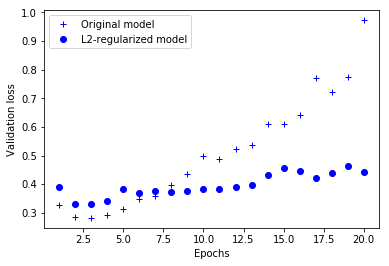

In [13]:
l2_model_val_loss = l2_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

In [14]:
# Keras 中不同的权重正则化项
from keras import regularizers
# L1 regularization
regularizers.l1(0.001)
# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)

# 添加 dropout 正则化

dropout 是神经网络最有效也最常用的正则化方法之一，它是由多伦多大学的 Geoffrey Hinton和他的学生开发的。对某一层使用 dropout，就是在训练过程中随机将该层的一些输出特征舍弃（设置为 0）。假设在训练过程中，某一层对给定输入样本的返回值应该是向量 [0.2, 0.5,1.3, 0.8, 1.1]。使用 dropout 后，这个向量会有几个随机的元素变成 0，比如 [0, 0.5,1.3, 0, 1.1]。 dropout 比率（dropout rate）是被设为 0 的特征所占的比例，通常在 0.2~0.5范围内。测试时没有单元被舍弃，而该层的输出值需要按 dropout 比率缩小，因为这时比训练时有更多的单元被激活，需要加以平衡。

假 设 有 一 个 包 含 某 层 输 出 的 Numpy 矩 阵 layer_output， 其 形 状 为 (batch_size,features)。训练时，我们随机将矩阵中一部分值设为

```python
# 训练时，舍弃 50%的输出单元
layer_output *= np.random.randint(0, high=2, size=layer_output.shape)
```

测试时，我们将输出按 dropout 比率缩小。这里我们乘以 0.5（因为前面舍弃了一半的单元）。
```python
# 测试时
layer_output *= 0.5
```

注意，为了实现这一过程，还可以让两个运算都在训练时进行，而测试时输出保持不变。这通常也是实践中的实现方式
```python
# 训练时
layer_output *= np.random.randint(0, high=2, size=layer_output.shape) 
# 注意，是成比例放大而不是成比例缩小
layer_output /= 0.5
```

**训练时对激活矩阵使用 dropout，并在训练时成比例增大。测试时激活矩阵保持不变**

![image.png](../img/04/dropout.png)

> 它为什么能够降低过拟合？ Hinton 说他的灵感之一来自于银行的防欺诈机制。用他自己的话来说：“我去银行办理业务。柜员不停地换人，于是我问其中一人这是为什么。他说他不知道，但他们经常换来换去。我猜想， 银行工作人员要想成功欺诈银行，他们之间要互相合作才行。这让我意识到，在每个样本中随机删除不同的部分神经元，可以阻止它们的阴谋，因此可以降低过拟合。”其核心思想是在层的输出值中引入噪声，打破不显著的偶然模式（Hinton 称之为阴谋）。如果没有噪声的话，网络将会记住这些偶然模式。

在 Keras 中，你可以通过 Dropout 层向网络中引入 dropout， dropout 将被应用于前面一层的输出。

```python
model.add(layers.Dropout(0.5))
```

In [17]:
# # 向 IMDB 网络中添加 dropout
# model = models.Sequential()
# model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(16, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(1, activation='sigmoid'))

# dpt_model_hist = dpt_model.fit(x_train, y_train,
#                                epochs=20,
#                                batch_size=512,
#                                validation_data=(x_test, y_test))

In [18]:
# dpt_model_val_loss = dpt_model_hist.history['val_loss']

# plt.plot(epochs, original_val_loss, 'b+', label='Original model')
# plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model')
# plt.xlabel('Epochs')
# plt.ylabel('Validation loss')
# plt.legend()

# plt.show()

总结一下，防止神经网络过拟合的常用方法包括：
* 获取更多的训练数据
* 减小网络容量
* 添加权重正则化
* 添加 dropout